# Koombea blogs analysis

In this notebook I wil make some visualization and statistical analysis to get some insights of our text data

In [1]:
import sys
sys.path.append('../koombea_blogs') # add koombea_blogs module
from config.settings import settings # import settings
import pandas as pd
import nltk
import sklearn
import matplotlib.pyplot as plt
from functools import reduce
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.decomposition as deco
import wordcloud as wd

%matplotlib inline
# %matplotlib widget

## Load Processed data

In [2]:
blogs = pd.read_csv(f"../data/{settings.DB_NAME}_processed_blogs.csv",
                    usecols=["post_name", "post_content_html", "tokenized_data", "lang", "data", "industry_slug"])

In [3]:
blogs.head(2)

,post_name,industry_slug,lang,post_content_html,data,tokenized_data
0,why-scalability-matters-for-your-app,hi-tech,en,"<span style=""font-weight: 400;"">Are you curiou...",\nAre you curious why scalable applications ar...,"['curious', 'scalable', 'application', 'popula..."
1,is-a-scrum-agile-development-process-right-for...,hi-tech,en,<strong>A Brief History of Scrum Agile Develop...,\nA Brief History of Scrum Agile Development: ...,"['history', 'scrum', 'agile', 'development', '..."


## Text Analysis

- frequency analysis
- tfidf analysis
- tsne analysis

In [4]:
def convert2list(string_list):
    """ Transform data from string "['hello', 'blog']" to a list ["hello", "blog"]
    Args:
        string_list (str): string list format
    Returns:
        parse list
    """
    # return json.loads(string_list.replace("\'", "\""))
    return [string.strip() for string in string_list.strip(r"\[|\]").replace("\'", "").split(",")]

In [5]:
def plot_extension(freqdist, n_top, reverse, **kwargs):
    """ Extension plot for frequency nltk statistic object
    """
    samples = ([item for item, _ in freqdist.most_common(n=n_top)] if not reverse
               else [item for item, _ in freqdist.most_common()[:-n_top:-1]])
    freqs = [freqdist[sample] for sample in samples]
    ylabel = "Counts"
    
    ax = plt.gca()
    ax.grid(True, color = "silver")
    if "linewidth" not in kwargs:
        kwargs["linewidth"] = 2
    if "title" in kwargs:
        ax.set_title(kwargs["title"])
        del kwargs["title"]
        
    ax.plot(freqs, **kwargs)
    ax.set_xticks(range(len(samples)))
    ax.set_xticklabels([str(s) for s in samples], rotation=90)
    ax.set_xlabel("Samples")
    ax.set_ylabel(ylabel)
    plt.show()
    
    return ax

In [6]:
def plot_frequency_words_info(words_fdist, n_top, reverse, title, figsize=(10, 10), **kwargs):
    """ Execute the plotting of frequency words information, and make configuration to plt.figure
    """
    plt.figure(figsize=figsize, tight_layout=True)
    ax = plot_extension(words_fdist, n_top, reverse, title=title, **kwargs)
    plt.show(ax)

In [7]:
def make_frequency_analysis(data, lang, n_top, title, reverse, figsize, **kwargs):
    """ Make frequency analysis plots by language to our data, languages must be 'es' or 'en'
    """
    tokenized_data = reduce(lambda l1, l2: l1 + l2,
                           map(convert2list, blogs[blogs.lang == lang].tokenized_data))
    words_fdist = nltk.probability.FreqDist(tokenized_data)
    plot_frequency_words_info(words_fdist, n_top=n_top, title=title,
                              reverse=reverse, figsize=figsize, **kwargs)

### English blogs analysis

Here we are going to analyze the blogs in english language

#### Most Frequents English words

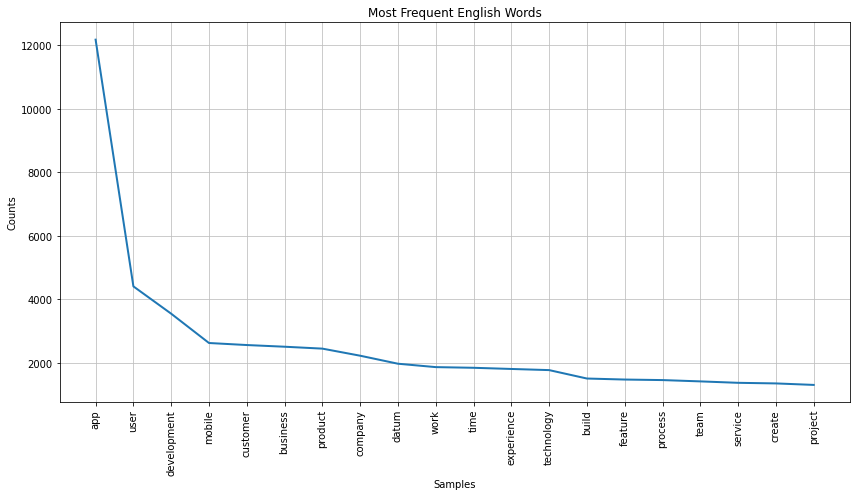

In [8]:
make_frequency_analysis(blogs, lang="en", n_top=20, title="Most Frequent English Words", reverse=False, figsize=(12, 7))

The word app is highly repeated across the blogs, the best move is to delete from our vocabulary; however the frequency information is not sufficient to determine is a word is not important or not. That's why we are going to use TF-IDF metric to analyze word's importance.

#### Less Frequents English words

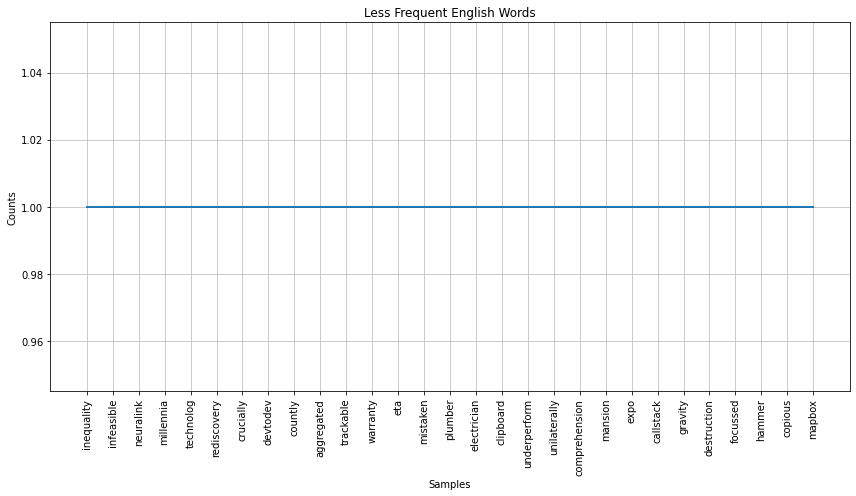

In [9]:
make_frequency_analysis(blogs, lang="en", n_top=30, title="Less Frequent English Words", reverse=True, figsize=(12, 7))

#### TFIDF analysis

In [10]:
def plot_words2stats_barline(ax, words, stats, xlabel, ylabel, **kwargs):
    """ Plot words vs statistics, using bar horizontal and lineal plots
    """
    if "linewidth" not in kwargs:
        kwargs["linewidth"] = 2
    if "title" in kwargs:
        ax.set_title(kwargs["title"])
        del kwargs["title"]
        
    ax.plot(stats, range(len(words))[::-1], **kwargs)
    ax.barh(range(len(words))[::-1], stats, align="center")
    ax.set_yticks(range(len(words))[::-1])
    ax.set_yticklabels(words, rotation=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

In [11]:
def plot_tfidf_mean_across_docs(vocab, mean_weights, lang, ntop=30, figsize=(5, 10), **kwargs):
    """ Plot tfidf mean across docs in our data
    """
    titles = [f"Most \"importance\" {lang} words in blogs",
              f"Less \"importance\" {lang} english words in blogs"]
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, **kwargs)
    vocab, mean_weights = zip(*sorted(zip(vocab, mean_weights),
                                  key=lambda x: x[1], reverse=True))
    plot_words2stats_barline(ax1, vocab[:ntop], mean_weights[:ntop],
                             xlabel="tfidf weights", ylabel="words", title=titles[0])
    plot_words2stats_barline(ax2, vocab[:-ntop:-1][::-1], mean_weights[:-ntop:-1][::-1],
                            xlabel="tfidf weights", ylabel="words", title=titles[1])
    plt.show()

##### Analysis of word's importance

In [12]:
corpus_en = [" ".join(tokens)
             for tokens in map(convert2list, blogs[blogs.lang == "en"].tokenized_data)]
tfidf_en = TfidfVectorizer()
tfidf_matrix_en = tfidf_en.fit_transform(corpus_en)
mean_weights_en = np.array(tfidf_matrix_en.mean(axis=0)).reshape(-1)

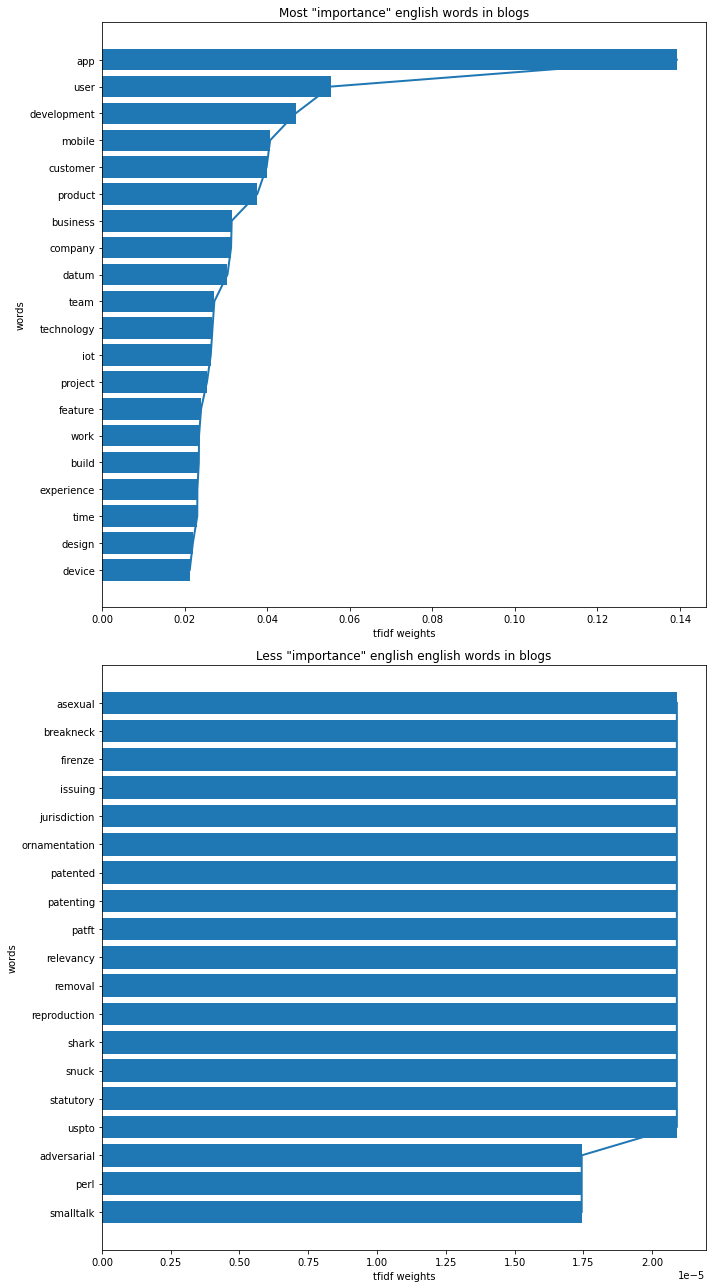

In [13]:
plot_tfidf_mean_across_docs(tfidf_en.get_feature_names(), mean_weights_en, lang="english",
                            figsize=(10, 18), tight_layout=True, ntop=20)

As we can see the word app is an important word across docs, using TF-IDF metric.

##### Analysis of docs topics

In [14]:
def get_words_importance_by_topics(decomposition_model, vocab, num_top_words=8):
    """
    Get word's importance in topics x words matrix 
    resulted from the matrix decomposition operation
    Args:
        decomposition_model: decomposition object trained model from sklearn
        vocab (List[str]): string list of vocabulary words 
        num_top_words (int): int with the quantity of words
    Return:
        most representing words by topics
    """
    matrix_V = decomposition_model.components_
    # lambda function that given a row topic vector 1 x num_words, return the most important ones
    get_top_words = lambda row: [(vocab[i], row[i]) for i in np.argsort(row)[:-num_top_words-1:-1]]
    topic_words = [get_top_words(row_v) for row_v in matrix_V]
    return topic_words

In [15]:
def plot_words_importance_by_topic(decomposition_model, vocab, num_top_words=4, figsize=(12, 8), **kwargs):
    """ Plot words importance by topic using matrix decomposition models from sklearn and vectorizers
    """
    top_words_by_topic = get_words_importance_by_topics(decomposition_model, vocab, num_top_words)
    nrows = (decomposition_model.n_components//2 if decomposition_model.n_components % 2 == 0
            else decomposition_model.n_components // 2 + 1)
    fig, ax_matrix = plt.subplots(nrows=nrows, ncols=2, figsize=figsize, squeeze = False, **kwargs)
    for index, ax_row in enumerate(ax_matrix):
        if index * 2 < len(top_words_by_topic):
            words, tfidf_stats = zip(*top_words_by_topic[index * 2])
            plot_words2stats_barline(ax_row[0], words, stats = tfidf_stats,
                                     xlabel="tfidf weights", ylabel="words", title="topic {}".format(index * 2 + 1))
        if (index * 2 + 1) < len(top_words_by_topic):
            words, tfidf_stats = zip(*top_words_by_topic[index * 2 + 1])
            plot_words2stats_barline(ax_row[1], words, stats = tfidf_stats,
                                    xlabel = "tfidf weights", ylabel="words", title="topic {}".format(index * 2 + 2))
    plt.show()

In [16]:
nmf_en = deco.NMF(n_components=20, init="nndsvd", max_iter=1000)
nmf_en.fit(tfidf_matrix_en)

NMF(init='nndsvd', max_iter=1000, n_components=20)

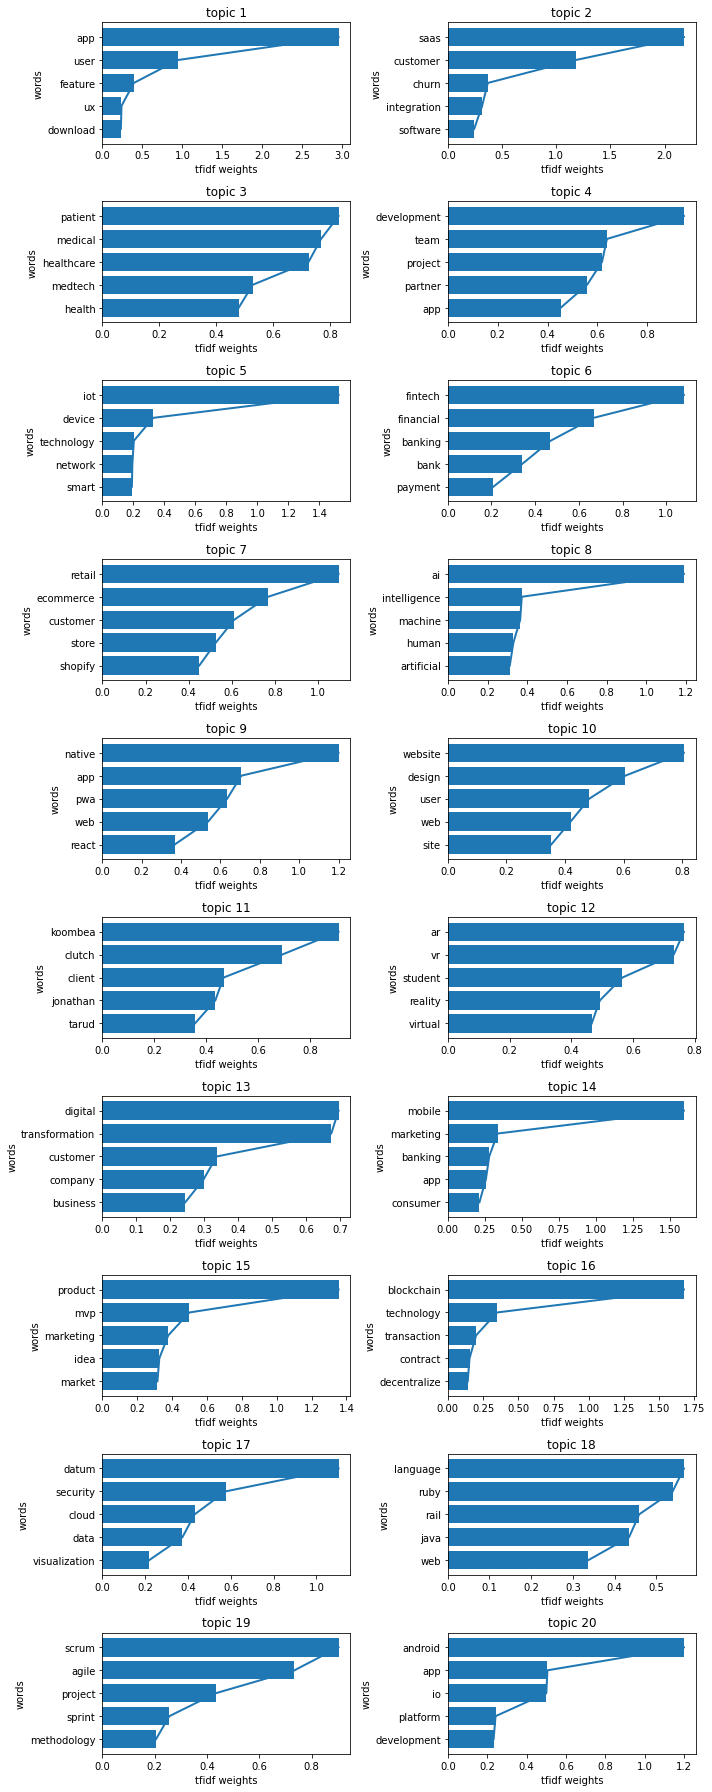

In [17]:
plot_words_importance_by_topic(nmf_en, vocab=tfidf_en.get_feature_names(), figsize=(10, 25), num_top_words=5, tight_layout=True)

##### Word Clouds of docs topics

In [18]:
def plot_wordcloud(ax, word2freq, title, max_words):
    """ Generate wordcloud and plot to given axes
    """
    wordcloud = wd.WordCloud(
        width=1500,
        height=500,
        background_color="white",
        max_words = max_words,
        max_font_size = 500,
        normalize_plurals = False
    )
    wordcloud.generate_from_frequencies(word2freq)
    ax.set_title(title)
    ax.imshow(wordcloud)
    ax.axis("off")

In [19]:
def plot_wordcloud_by_topicdist(decomposition_model, vocab, max_words=24, **kwargs):
    """ Plot word clound by words in topic distribution from a decomposition model object trained from sklearn
    """
    nrows = (decomposition_model.n_components // 2 if decomposition_model.n_components % 2 == 0
             else decomposition_model.n_components // 2 + 1)
    fig, axes_matrix = plt.subplots(nrows = nrows, ncols = 2, squeeze = False, **kwargs)
    # get important word distribution
    top_words_by_topic = get_words_importance_by_topics(decomposition_model, vocab, max_words)
    
    for index, axes_row in enumerate(axes_matrix):
        if index * 2 < len(top_words_by_topic):
            plot_wordcloud(axes_row[0], dict(top_words_by_topic[index * 2]),
                           title=f"topic {index * 2 + 1}", max_words=max_words)
        if index * 2 + 1 < len(top_words_by_topic):
            plot_wordcloud(axes_row[1], dict(top_words_by_topic[index * 2 + 1]),
                           title=f"topic {index * 2 + 2}", max_words=max_words)
    plt.show()

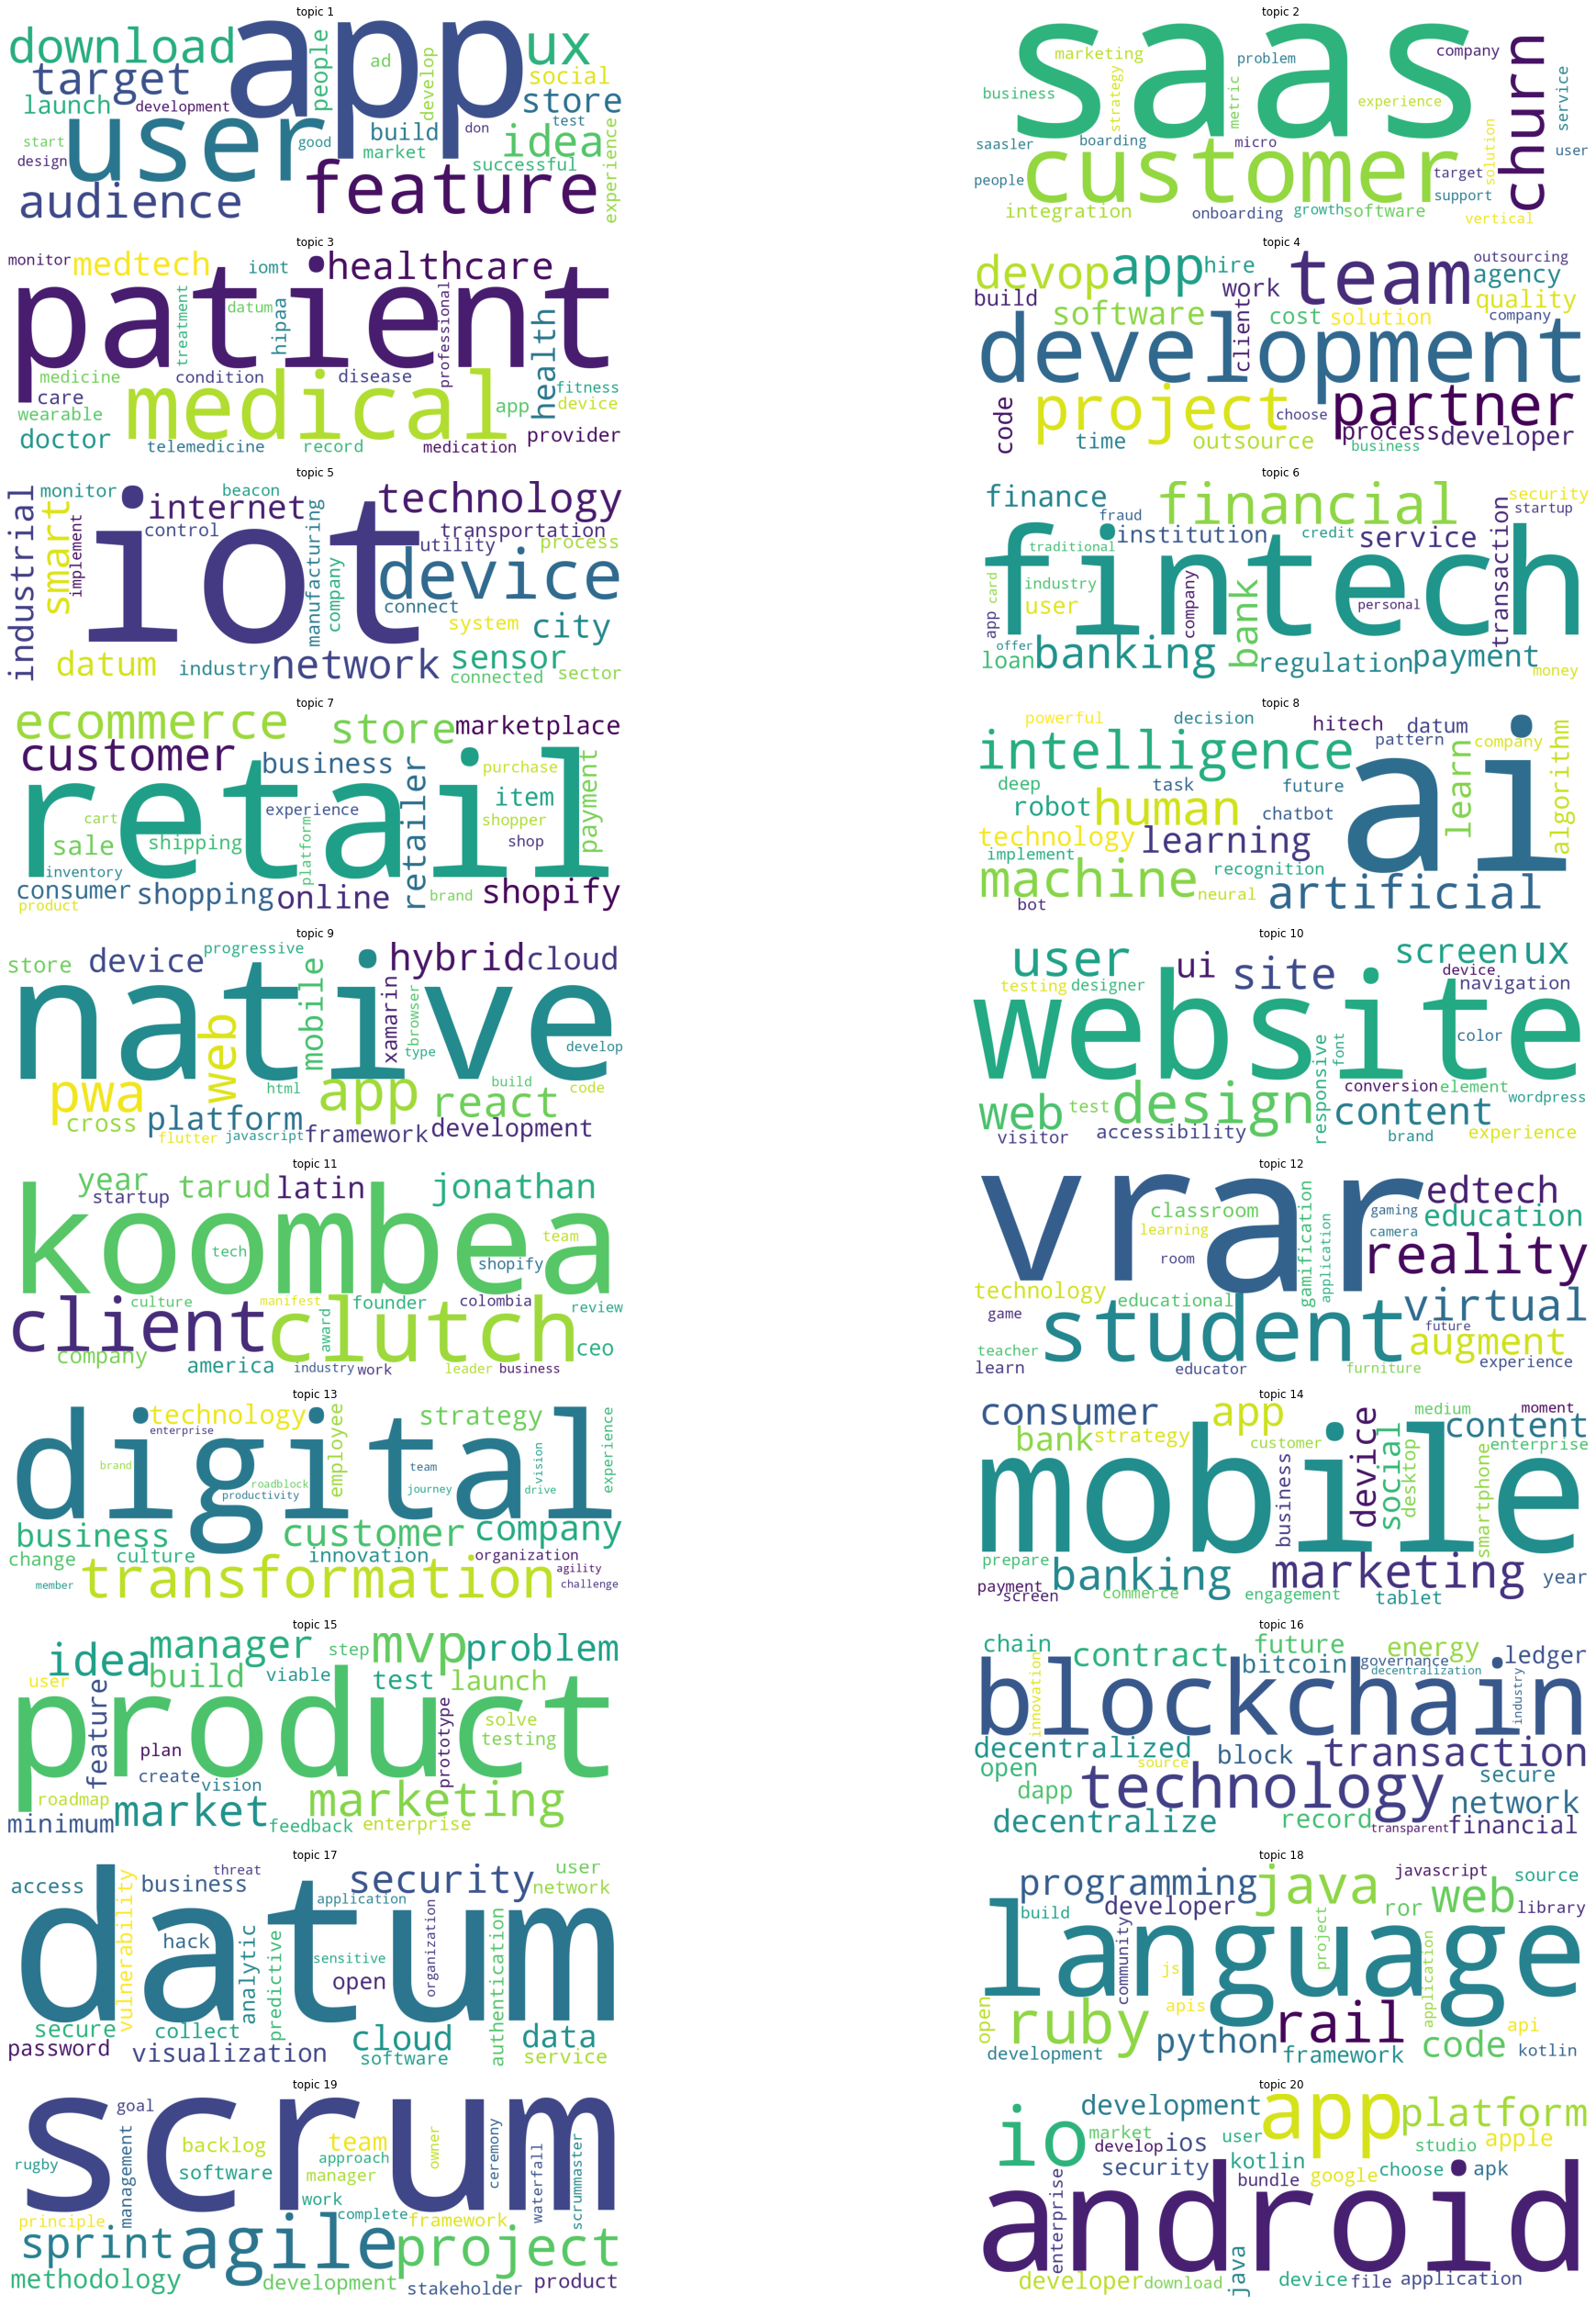

In [20]:
plot_wordcloud_by_topicdist(nmf_en, vocab=tfidf_en.get_feature_names(), figsize=(35, 35), tight_layout=True)

### Spanish blogs analysis

Here we are going to analyze the blogs in spanish language

#### Most Frequents Spanish Words

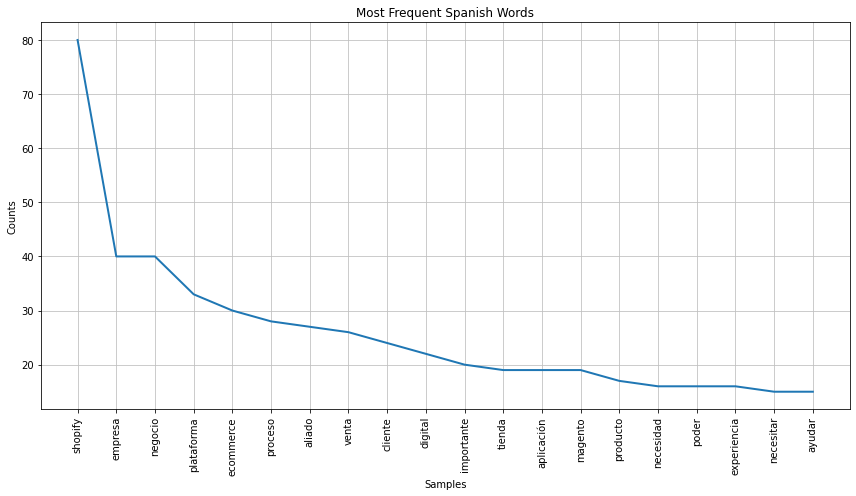

In [21]:
make_frequency_analysis(blogs, lang="es", n_top=20, title="Most Frequent Spanish Words", reverse=False, figsize=(12, 7))

#### Less Frequents Spanish Words

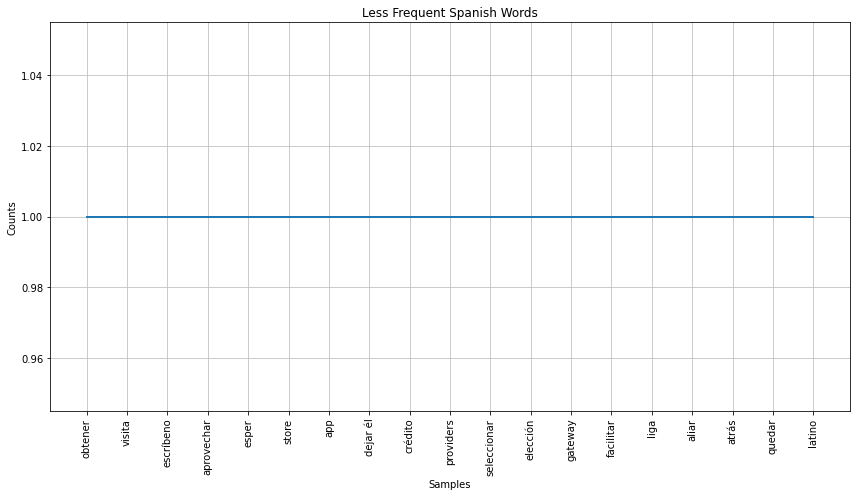

In [22]:
make_frequency_analysis(blogs, lang="es", n_top=20, title="Less Frequent Spanish Words", reverse=True, figsize=(12, 7))

for this case is not necessary to remove the word app because is one of the less frequent words.

#### TFIDF Analysis

##### Analysis of word's importance

In [23]:
corpus_en = [" ".join(tokens)
             for tokens in map(convert2list, blogs[blogs.lang == "es"].tokenized_data)]
tfidf_es = TfidfVectorizer()
tfidf_matrix_es = tfidf_es.fit_transform(corpus_en)
mean_weights_es = np.array(tfidf_matrix_es.mean(axis=0)).reshape(-1)

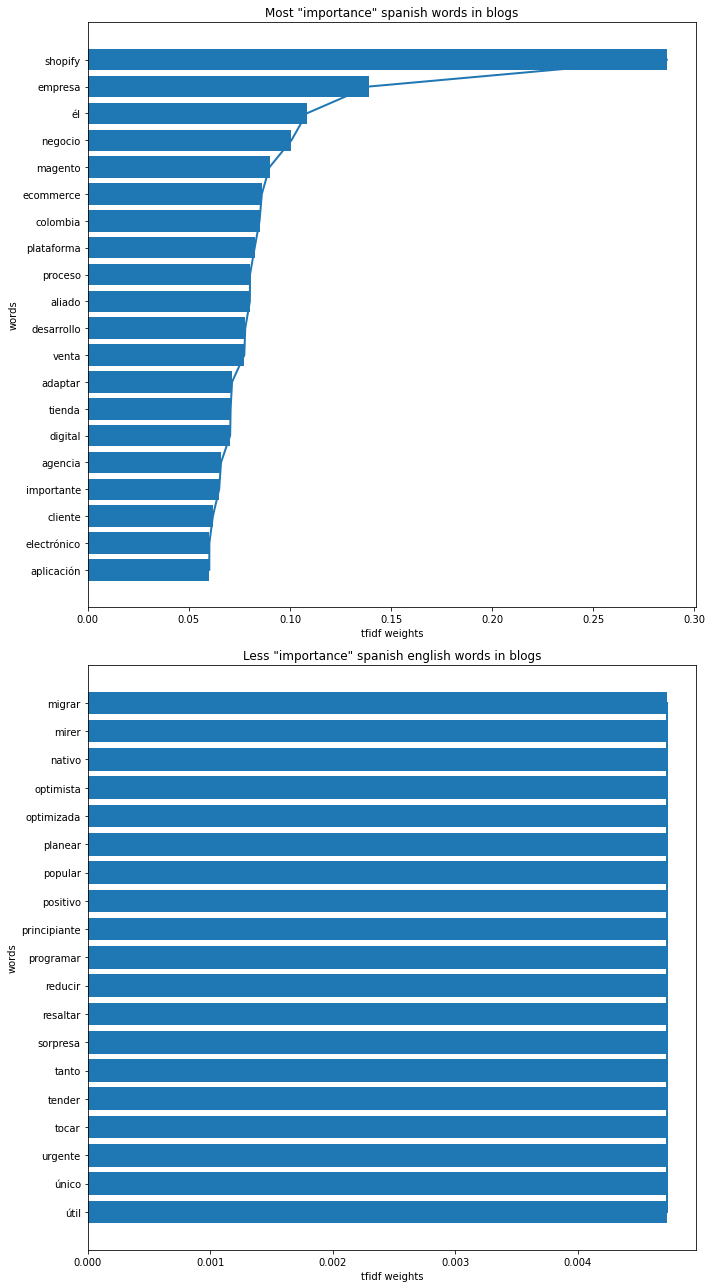

In [24]:
plot_tfidf_mean_across_docs(tfidf_es.get_feature_names(), mean_weights_es, lang="spanish",
                            figsize=(10, 18), tight_layout=True, ntop=20)

##### Analysis of docs topics

In [25]:
nmf_es = deco.NMF(n_components=2, init="nndsvd", max_iter=1000)
nmf_es.fit(tfidf_matrix_es)

NMF(init='nndsvd', max_iter=1000, n_components=2)

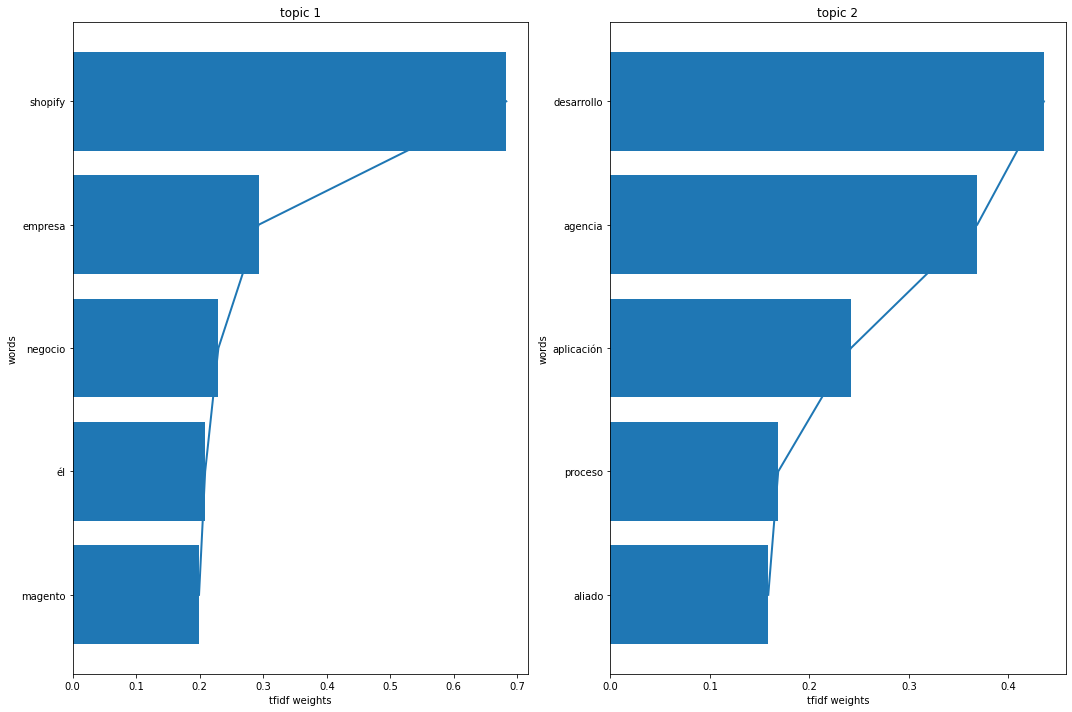

In [26]:
plot_words_importance_by_topic(nmf_es, vocab=tfidf_es.get_feature_names(), figsize=(15, 10), num_top_words=5, tight_layout=True)

##### Word Clouds of docs topics

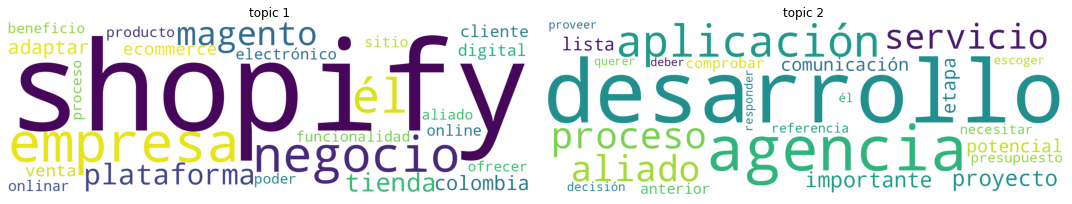

In [27]:
plot_wordcloud_by_topicdist(nmf_es, vocab=tfidf_es.get_feature_names(), figsize=(15, 15), tight_layout=True)